In [1]:
import numpy as np
import pandas as pd

In [2]:
nutrition = pd.read_csv("../data/features_nutrition.csv", delimiter=";", index_col=0)
seasonal = pd.read_csv("../data/recipe_seasonality_features.csv", index_col=0)
rating = pd.read_csv("../data/recipes_feature_rating_full.csv", index_col=0)
complexity = pd.read_csv("../data/recipes_features_complexity.csv", index_col=0)
ingredients = pd.read_csv("../data/features_axes_ingredients.csv", index_col=0)

recipes = (nutrition
           .merge(seasonal, left_index=True, right_index=True)
           .merge(rating, left_index=True, right_index=True)
           .merge(complexity, left_index=True, right_index=True)
           .merge(ingredients, left_index=True, right_index=True)
           )


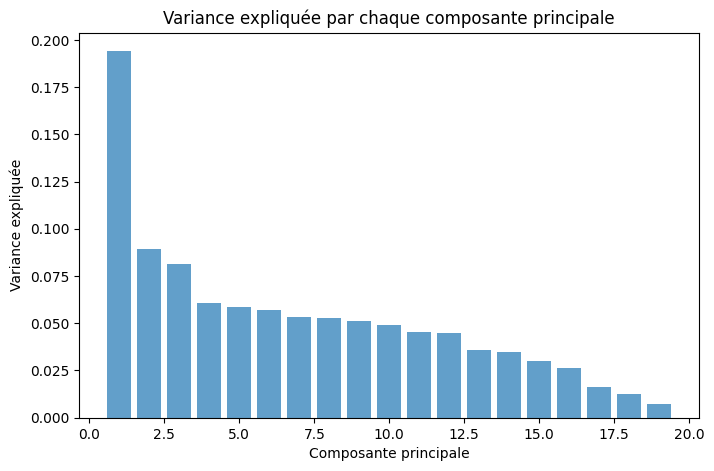

In [3]:
from sklearn.decomposition import PCA

# Sélectionner les variables pour la PCA
features = recipes[['energy_density', 'protein_ratio', 'fat_ratio',
       'nutrient_balance_index', 'inter_doy_sin_smooth',
       'inter_doy_cos_smooth', 'inter_strength', 'n_interactions',
        'bayes_mean', 'n_steps_z', 'n_ingredients_z',
       'minutes_log', 'score_sweet_savory', 'score_spicy_mild', 'score_lowcal_rich',
       'score_vegetarian_meat', 'score_solid_liquid', 'score_raw_processed',
       'score_western_exotic']]
# Standardiser les données
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
# Appliquer la PCA
pca = PCA(n_components=len(features.columns))
principal_components = pca.fit_transform(features_scaled)
# Créer un DataFrame avec les composantes principales
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])], index=recipes.index)
# Graphique des valeurs propres
import matplotlib.pyplot as plt
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée par chaque composante principale')
plt.show()



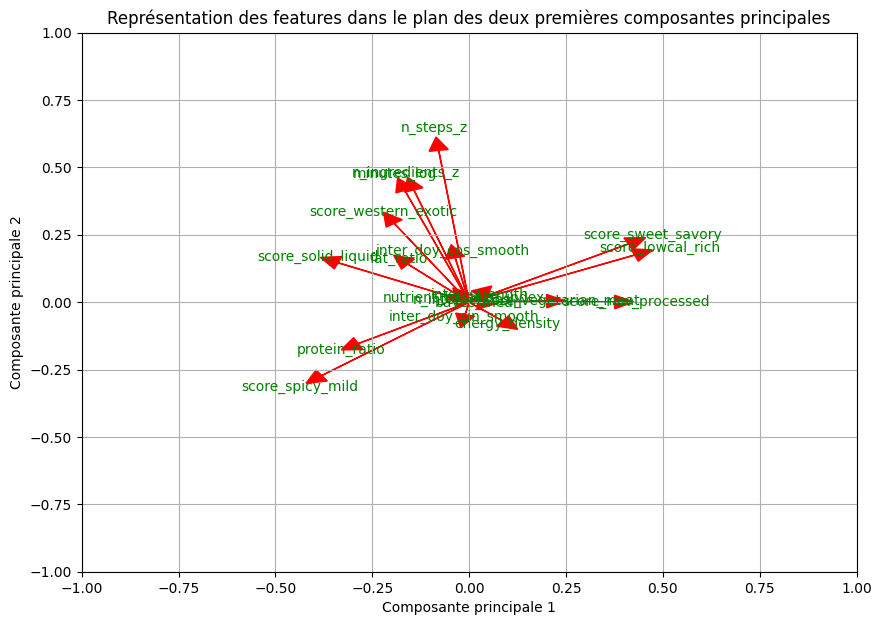

In [4]:
# Représentation des features dans le plan des deux premières composantes principales
plt.figure(figsize=(10, 7))
for i, feature in enumerate(features.columns):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i],
              head_width=0.05, head_length=0.05, fc='r', ec='r')
    plt.text(pca.components_[0, i] * 1.15, pca.components_[1, i] * 1.15,
             feature, color='g', ha='center', va='center')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Représentation des features dans le plan des deux premières composantes principales')
plt.grid()
plt.show()

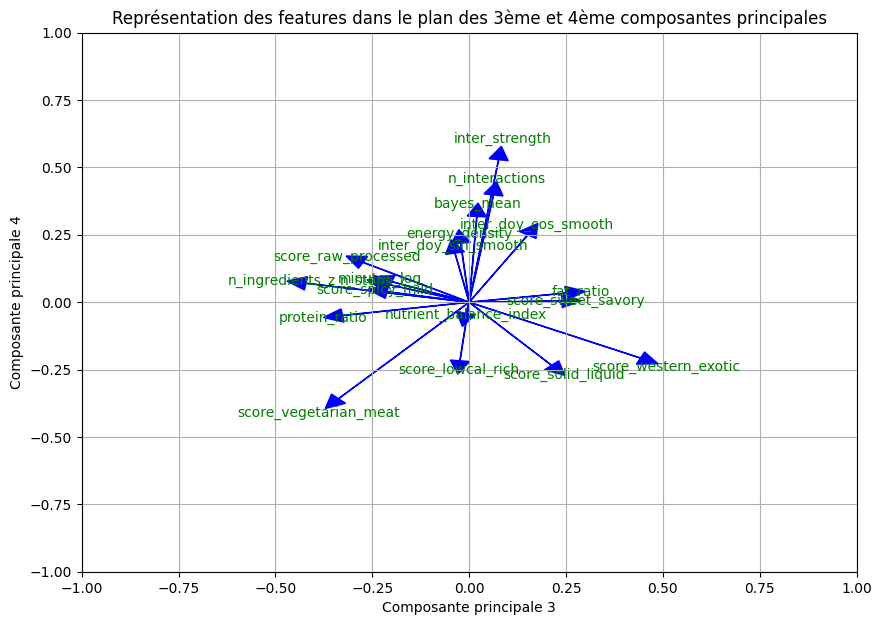

In [5]:
# Représentation des variables sur le plan des 3ème et 4ème composantes principales
plt.figure(figsize=(10, 7))
for i, feature in enumerate(features.columns):
    plt.arrow(0, 0, pca.components_[2, i], pca.components_[3, i],
              head_width=0.05, head_length=0.05, fc='b', ec='b')
    plt.text(pca.components_[2, i] * 1.15, pca.components_[3, i] * 1.15,
             feature, color='g', ha='center', va='center')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('Composante principale 3')
plt.ylabel('Composante principale 4')
plt.title('Représentation des features dans le plan des 3ème et 4ème composantes principales')
plt.grid()
plt.show()  

In [6]:
# Afficher les contributions des variables aux composantes principales
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(features.columns))], index=features.columns)
print("Contributions des variables aux composantes principales :")
print(loadings) 

Contributions des variables aux composantes principales :
                             PC1       PC2       PC3       PC4       PC5  \
energy_density          0.086499 -0.069381 -0.021749  0.219614 -0.311646   
protein_ratio          -0.286266 -0.153377 -0.326615 -0.049164  0.130033   
fat_ratio              -0.157929  0.141373  0.250018  0.033980 -0.044416   
nutrient_balance_index -0.011168  0.014008 -0.007958 -0.040849  0.065081   
inter_doy_sin_smooth   -0.010379 -0.045959 -0.036526  0.182294  0.285682   
inter_doy_cos_smooth   -0.035993  0.165142  0.151254  0.249560 -0.033935   
inter_strength          0.023770  0.024454  0.075958  0.528774  0.384330   
n_interactions         -0.015475  0.006489  0.062790  0.398091  0.308903   
bayes_mean              0.021671 -0.001389  0.019821  0.318054  0.264497   
n_steps_z              -0.078626  0.563412 -0.215924  0.068001 -0.068851   
n_ingredients_z        -0.142669  0.416571 -0.420993  0.070186 -0.026211   
minutes_log            -0.1659

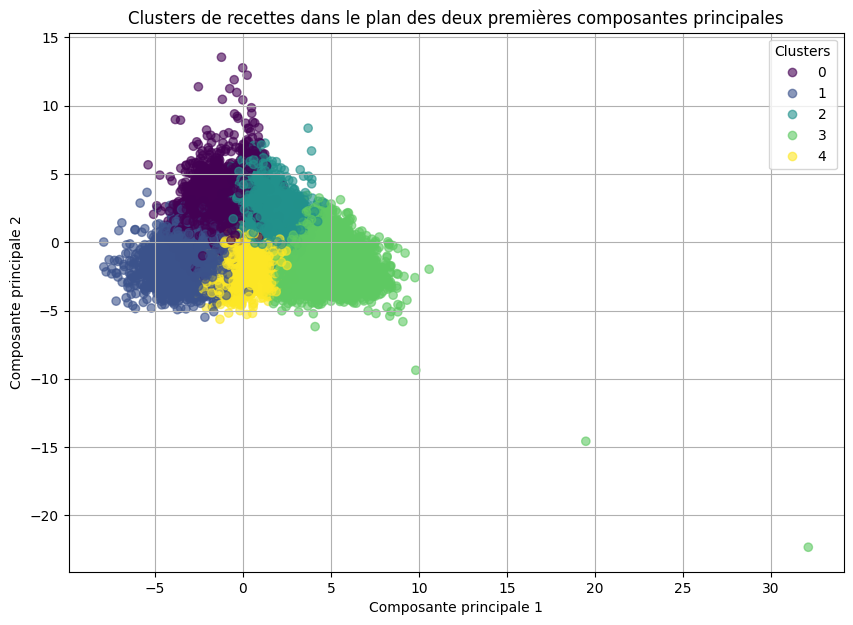

Caractéristiques moyennes des clusters :
         energy_density  protein_ratio  fat_ratio  nutrient_balance_index  \
cluster                                                                     
0              4.800520       0.121584   0.067445                0.035880   
1              4.928966       0.105762   0.077857                0.020825   
2              6.896980       0.033257   0.066936               -0.105571   
3             15.747312       0.028523   0.025914               -0.512825   
4              5.415596       0.083200   0.078486               -0.044663   

         inter_doy_sin_smooth  inter_doy_cos_smooth  inter_strength  \
cluster                                                               
0                    0.023014              0.041345        0.201050   
1                    0.018395              0.035287        0.203220   
2                    0.006046              0.046451        0.208696   
3                    0.016206             -0.013926        0.216

In [7]:
# K-means clustering sur les 12 premières composantes principales
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
recipes['cluster'] = kmeans.fit_predict(pca_df.iloc[:, :12])   
# Représentation des clusters dans le plan des deux premières composantes principales
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=recipes['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.title('Clusters de recettes dans le plan des deux premières composantes principales')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid()
plt.show()
# Caractériser les clusters par les variables d'origine
cluster_characteristics = recipes.groupby('cluster')[features.columns].mean()
print("Caractéristiques moyennes des clusters :")
print(cluster_characteristics)






In [8]:
# Construire un dataframe avec les variables d'origine en ligne, les clusters en colonne. 
# Pour chaque cellule, la statistique de student (signée) entre le cluster et le reste des données.
from scipy.stats import ttest_ind
cluster_stats = pd.DataFrame(index=features.columns, columns=[f'cluster_{i}' for i in range(5)], dtype=float)
for i in range(5):
    cluster_data = recipes[recipes['cluster'] == i][features.columns]
    rest_data = recipes[recipes['cluster'] != i][features.columns]
    for feature in features.columns:
        t_stat, p_val = ttest_ind(cluster_data[feature], rest_data[feature], equal_var=False)
        cluster_stats.at[feature, f'cluster_{i}'] = t_stat
print("Statistiques de Student (signées) entre chaque cluster et le reste des données :")
print(cluster_stats)

Statistiques de Student (signées) entre chaque cluster et le reste des données :
                         cluster_0   cluster_1   cluster_2   cluster_3  \
energy_density          -36.148350  -33.551362    7.588376   19.941736   
protein_ratio           166.793274  122.327662 -328.693831 -185.411567   
fat_ratio                -5.172088   73.087685  -10.626674 -180.335717   
nutrient_balance_index    8.496124    7.124654   -2.435469   -3.573841   
inter_doy_sin_smooth      9.840516    2.781519  -20.159562   -0.554245   
inter_doy_cos_smooth     35.955671   28.797787   50.137344  -27.247515   
inter_strength          -13.433130   -8.385894    7.419739   14.866627   
n_interactions          -10.560816   11.063292    4.201414  -18.876529   
bayes_mean               -9.832820  -10.548887  -14.228260   24.012570   
n_steps_z               164.118030 -101.183857   81.341906 -173.411955   
n_ingredients_z         287.302282 -132.823569  -13.170764 -256.036902   
minutes_log             176.365

In [9]:
# explort de cluster_stats
cluster_stats.to_csv('../data/cluster_stats.csv', index=True)


In [17]:

# Affichage des noms des 20 recettes les plus proches du centre de chaque cluster
from sklearn.metrics import pairwise_distances

# Calcul des distances entre chaque centre et chaque point
distances = pairwise_distances(centers, pca_df.iloc[:, :12])

# Pour chaque cluster, on récupère les 20 indices les plus proches
n_neighbors = 20
for i in range(len(centers)):
    # np.argsort trie les indices des distances de plus petit à plus grand
    closest_indices = np.argsort(distances[i])[:n_neighbors]
    
    print(f"\nCluster {i} – 20 recettes les plus proches du centre :")
    for idx in closest_indices:
        recipe_name = recipes.iloc[idx].get('name_x', 'unknown')
        print(f"  - {recipe_name}")









Cluster 0 – 20 recettes les plus proches du centre :
  - chicken in onion buttermilk gravy   slow cooker
  - shrimp   crab tomato cream pasta
  - southwestern ranch salad  rsc
  - tomato cabbage soup
  - roasted butternut squash and tomato soup
  - stuffed manicotti verde
  - helen s cabbage salad
  - german slumgullion a pot of garden bounty
  - deep fried cajun turkey
  - smothered pork chops  crock pot
  - spinach and rice stuffed chicken breast
  - country style chicken and vegetables
  - my favorite lasagna
  - thai curry chicken with sweet potato
  - cornmeal fried oysters with red cabbage and sausage
  - 7 samurai vegan soup
  - moroccan meatballs with herb couscous
  - spicy cayenne toasts with sun dried tomato spread
  - noodles with bean sprouts  coriander and mint
  - zucchini olive and cheese quesadillas

Cluster 1 – 20 recettes les plus proches du centre :
  - buttered noodles with eggs and parmesan cheese
  - grannydragon s cock a leekie soup
  - rice uruguayan
  - bubbl

In [20]:
# exporter le dataframe final avec les clusters et les deux premières composantes principales
recipes = recipes[["name_x", "cluster"]].merge(pca_df[['PC1', 'PC2']], left_index=True, right_index=True)
recipes.to_csv('../data/recipes_clustering_pca.csv', index=True, columns=["name_x", 'cluster', 'PC1', 'PC2'])
